In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(N=[1000, 2000, 4000, 8000])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [58]:
#Network size
N = 1000
#Random connectivity
g = 2.2
J = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

#Structure
s = 0
sigma_diag = 1.6
sigma_off = 0.8
sigma_mn = np.array([[sigma_diag, -sigma_off],
                     [sigma_off, sigma_diag]])
sigma_mm = np.eye(2)
n_var = 4
sigma_nn = n_var * np.eye(2)

covariance_top = np.hstack([sigma_mm, sigma_mn])
covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
covariance = np.vstack([covariance_top, covariance_bot])

loadings = np.random.multivariate_normal(np.zeros(4), covariance, size=N)

#R = int(np.sqrt(N))
R = 2

M = 0
for r in range(R//2):
    m1 = loadings[:,0]
    m2 = loadings[:,1]
    n1 = loadings[:,2]
    n2 = loadings[:,3]
    M += np.multiply.outer(m1, n1) + np.multiply.outer(m2, n2)
    
#Combine into one connectivity
W = J + s*M / N

In [59]:
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime = lambda x: np.exp(-(np.pi/4)*x**2)
def run_sim(T_sim, T_eval, dt, W, N_batch=1):
    device = W.device
    N = W.shape[0]
    eval_iter = int(T_eval / dt)
    Nt = int(T_sim / dt)
    N_save = int(T_sim / T_eval)
    #define stuff
    x_save = torch.zeros(N_save, N_batch, N, device=device)
    x = torch.randn(N_batch, N, device=device) * torch.std(W).item() * np.sqrt(N)
    x_save[0] = x
    r_lpf = x.clone()
    r_lpf_save = torch.zeros_like(x_save)
    r_lpf_save[0] = r_lpf
    #run
    for i in range(1, Nt):
        r = phi_torch(x)
        r_lpf += dt*(-r_lpf + r)
        x += dt*(-x + torch.mm(r, W.T))
        if i % eval_iter == 0:
            x_save[i//eval_iter] = x
            r_lpf_save[i//eval_iter] = r_lpf
    return x_save, r_lpf_save

In [61]:
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.05
dt_save = 0.05
x_save, r_lpf_save = run_sim(1000, dt_save, dt, W_)


In [62]:
T_initial = 100
x = x_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
psi_emp = phi_prime(x).mean(1)
phi_lpf = r_lpf_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
kappa_emp = phi_lpf.dot(np.array([n1, n2]).T) / N
Delta_emp = np.fft.irfft((np.abs(np.fft.rfft(x, axis=0, norm='ortho'))**2).mean(1))
#m = np.array([m1, m2])
#U, S, VT = np.linalg.svd(x)
#v1, v2 = VT[:2,:]
#alignment_mat = np.array([v1, v2]).dot(np.array([m1,m2]).T)
#alignment = np.linalg.norm(alignment_mat) / np.sqrt(2)

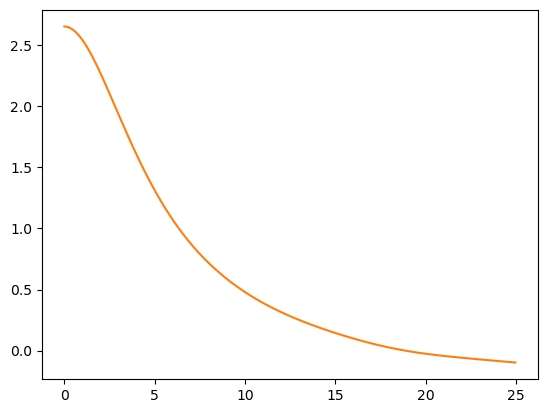

In [67]:
time_emp = np.arange(0, 25, 0.05)
fig = plt.figure()
plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=1)

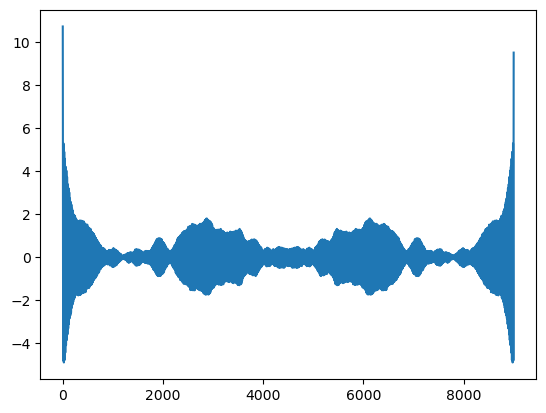

In [57]:
plt.plot(np.fft.irfft((np.abs(np.fft.rfft(x, axis=0, norm='ortho'))**2).mean(1)))

In [41]:
freq = np.fft.fftfreq(len(x[:,0]), 0.01)
power = (np.abs(np.fft.fft(x, axis=0))**2).mean(1)

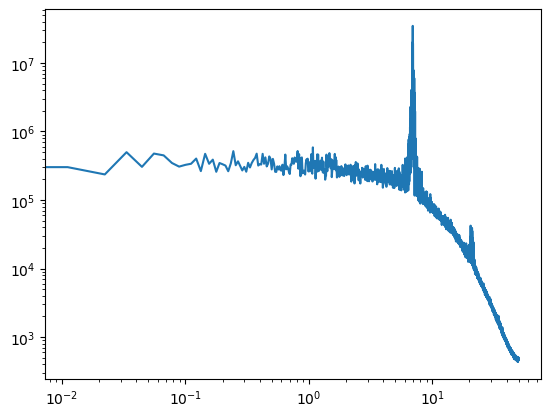

In [42]:
plt.plot(freq[:len(freq)//2], power[:len(freq)//2])
plt.xscale('log')
plt.yscale('log')

In [7]:
#svca = shared_component_variance_analysis(x, time_chunk_steps=100)

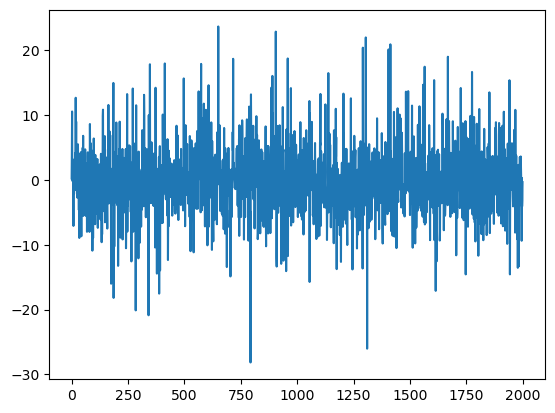

In [8]:
#plt.plot(svca)

In [43]:
x_demeaned = x - x.mean(0)

In [44]:
C = x_demeaned.T.dot(x_demeaned)/(x.shape[0] - 1)

In [45]:
eigs, vecs = np.linalg.eig(C)

Text(0, 0.5, 'Log var explained')

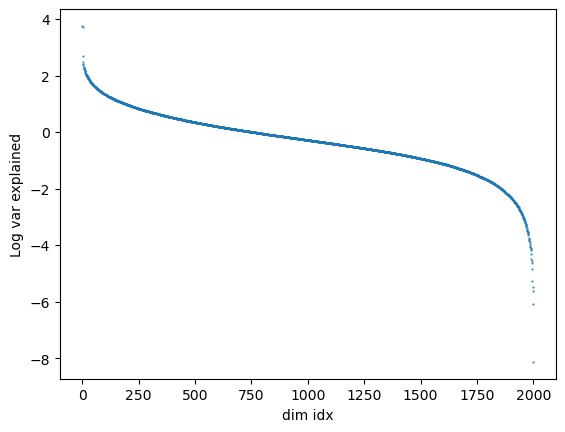

In [46]:
plt.plot(sorted(np.log10(np.abs(eigs)))[::-1], '.', markersize=1)
plt.xlabel('dim idx')
plt.ylabel('Log var explained')

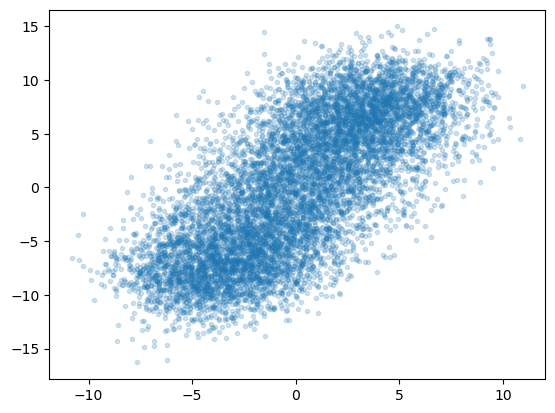

In [48]:
plt.plot(x_demeaned.dot(vecs[0]), x_demeaned.dot(vecs[1]), '.', alpha=0.2)

In [ ]:
#dt = 0.01
#time_mft = np.arange(0, 25, dt)
#mft = run_low_rank_dmft(g=g, s=s, T=50, dt=dt)
#Delta = mft['Delta']
#Delta_ = np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)]
#x_noise_mft = Delta_[0] - np.amax(Delta_[int(5/dt):])
#x_noise_emp = Delta_emp[0] - np.amax(Delta_emp[int(5/0.5):])
#noises = np.array([x_noise_mft, x_noise_emp])

In [ ]:
#xx_ts = np.einsum('it, is -> its', x.T, x.T)

In [ ]:
#window = 100
#N_traces = x_ts.shape[1] - window
#autocov_curves = np.zeros((N_traces, N, window))
#for i in range(N_traces):
#    autocov_curves[i] += x_ts[:,i,i:i+window]

In [ ]:
#plt.plot(autocov_curves.mean(0).mean(0))

In [ ]:
#plt.imshow(xx_ts.mean(0), cmap='RdBu_r')

In [ ]:
#fig, ax = plt.subplots(1, 2, figsize=(4, 2))
#ax[0].plot(np.diag(xx_ts.mean(0)))
#ax[0].set_title('$\Delta(t, t)$')
#ax[1].plot(np.diag(xx_ts.mean(0)), psi_emp, '.')
#ax[1].set_title('$\Delta(t, t) vs. \psi(t)$')

In [ ]:
#plt.plot(np.diag(x_ts.mean(0)), psi_emp, '.')
#plt.plot()

In [ ]:
# Assuming 'data' is your dataset (numpy array)
# Convert it to a PyTorch tensor and standardize
x = (x - x.mean(0))/x.std(0)
data_tensor = torch.tensor(x.T.dot(x), dtype=torch.float32)
#data_tensor = (data_tensor - torch.mean(data_tensor, axis=0)) / torch.std(data_tensor, axis=0)

# Move the tensor to GPU
data_tensor_gpu = data_tensor.to(0)

def power_iteration(A, num_iter=100):
    """
    Compute the principal eigenvector using the power iteration method.
    Args:
    - A: The input tensor (data matrix).
    - num_iter: Number of iterations to run the power iteration.
    Returns:
    - principal_eigenvector: The principal eigenvector of the matrix A.
    """
    b_k = torch.randn(A.size()[1], device=A.device)
    for _ in range(num_iter):
        # Calculate the matrix-by-vector product Ab
        b_k1 = torch.mv(A, b_k)
        
        # Calculate the norm
        b_k1_norm = torch.norm(b_k1)
        
        # Re normalize the vector
        b_k = b_k1 / b_k1_norm
    
    return b_k

def compute_top_pcs(data, n_components=2):
    """
    Compute the top 'n_components' principal components of 'data' using power iteration.
    Args:
    - data: The input data tensor.
    - n_components: Number of principal components to compute.
    Returns:
    - pcs: Principal components as columns in a matrix.
    """
    pcs = []
    A = data.clone()
    for _ in range(n_components):
        pc = power_iteration(A)
        pcs.append(pc)
        # Deflate the matrix
        A -= torch.ger(torch.mv(A, pc), pc)
    
    return torch.stack(pcs).T

# Compute the top 2 PCs
#top_pcs = compute_top_pcs(data_tensor_gpu, n_components=2)

# Move the result back to CPU if needed
#top_pcs_cpu = top_pcs.cpu()

# Convert back to numpy array if needed
#top_pcs_numpy = top_pcs_cpu.numpy()

# Example usage
# data_tensor_gpu is your data tensor on the GPU
#top_pcs = compute_top_pcs(data_tensor_gpu, n_components=2)


In [ ]:
#alignment_mat = top_pcs_numpy.T.dot(np.array([m1,m2]).T)
#alignment = np.linalg.norm(alignment_mat) / np.sqrt(2)

In [ ]:
if prototype:
    plt.figure()
    plt.plot(kappa_emp[:,0], kappa_emp[:,1], alpha=0.8, linewidth=0.3)
    U, S, VT = np.linalg.svd(eta)
    eta_proj = eta.dot(VT[:2,:].T)
    plt.plot(eta_proj[:,0], eta_proj[:,1], alpha=0.8, linewidth=0.3)

    U, S, VT = np.linalg.svd(x)
    x_perp = x - x.dot(VT[:2,:].T.dot(VT[:2,:]))

    Delta_perp_emp = np.fft.irfft((np.abs(np.fft.rfft(x_perp, axis=0, norm='ortho'))**2).mean(1))

    Delta_eta_emp = np.fft.irfft((np.abs(np.fft.rfft(eta, axis=0, norm='ortho'))**2).mean(1))
    time_emp = np.arange(0, 100, 0.5)
    fig = plt.figure()
    plt.plot(time_emp, Delta_perp_emp[:len(time_emp)], color='C1', alpha=1)

In [ ]:
#processed_data = compute_approximate_participation_coefficient(x, n_derangments=50)
processed_data = np.array(sorted(np.log10(np.abs(eigs)))[::-1])
#processed_data = alignment

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [11]:
###Truncate file above
file_name = 'limit_cycles_torch_sims'
job_name = 'spectra_scaling_N'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook limit_cycles_torch_sims.ipynb to script
[NbConvertApp] Writing 13596 bytes to limit_cycles_torch_sims.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac799535ad0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac799535ad0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [12]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/spectra_scaling_N/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py
mft-theory/cluster/process_results.py
mft-theory/cluster/start_jupyter_notebook.py
mft-theory/cluster/submit_jobs.py
mft-theory/cluster/sync_cluster.py
mft-theory/core/
mft-theory/core/Simulation.py
mft-theory/core/Time_Cts_RNN.py
mft-theory/core/__init

In [ ]:
job_id_1 = submit_job(job_script_path, n_jobs)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [5]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'spectra_scaling_N'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [6]:
results_array.shape

(4, 1, 8000)

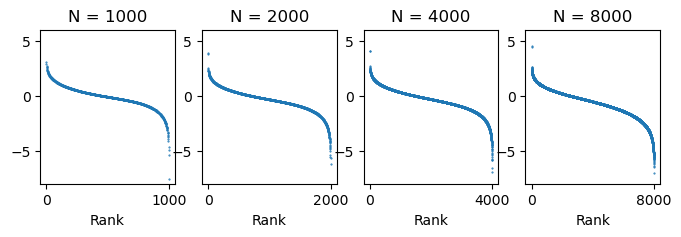

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    N = configs_array['N'][i]
    ax[i].plot(list(range(N)), results_array[i,0,:N], '.', markersize=1)
    ax[i].set_ylim([-8, 6])
    ax[i].set_xlabel('Rank')
    ax[i].set_xticks([0, N])
    ax[i].set_title('N = {}'.format(N))

In [ ]:
fig, ax = plt.subplots(20, 20, figsize=(20, 20))
idx = [0, 1] + list(np.arange(2, 4000, 50))
for i in range(0, 20):
    for j in range(0, 20):
        ax[19-j,i].plot(idx, results_array[i,j,0,idx], '.', markersize=1)
        ax[19-j,i].set_ylim([-8, 6])
        ax[19-j,i].axis('off')
#ig.savefig('figs/g_s_log_spectra.pdf')

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(16, 4))
for i_ax in range(10):
    for i in range(4):
        for j in range(5):
            ax[i_ax].plot(configs_array['N'], results_array[:,i,i_ax, j], '.', color='C0', alpha=0.2)
    ax[i_ax].plot(configs_array['N'], 2/np.array(configs_array['N']), 'k')
    ax[i_ax].set_yscale('log')
    ax[i_ax].set_xlabel('N')
    ax[i_ax].set_xticks(configs_array['N'], ['2k', '4k', '8k'])
    ax[i_ax].set_ylim([0.0001, 0.3])
ax[0].set_title('Pure chaos')
ax[0].set_ylabel('PR x')
ax[-1].set_title('Pure structure')

In [ ]:
time_emp = np.arange(0, 25, 0.5)
for i in range(2):
    for j in range(6):
        for k in range(5):
            plt.plot(time_emp, results_array[i,j,k,:len(time_emp)]/results_array[i,j,k,0], color='C{}'.format(j),
                     alpha=0.5)

In [ ]:
v = results_array.squeeze()
plt.plot(configs_array['g'], v[:,0])
plt.plot(configs_array['g'], v[:,1], '.')
plt.xlabel('g')
plt.ylabel('x noise')
plt.title('s = 2.6')

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 1
for i in range(5):
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp)], color='C2')
    #ax[i].set_xticks([])
    ax[i].set_yticks([0, 1])
    ax[i].set_ylim([0, 1])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 5
for i in range(5):
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 0], color='C1')
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 1], color='C1')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))
#plt.ylim([0, 1])

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 4
for i in range(5):
    ax[i].plot(results_array[i, i_seed, :len(time_emp), 0], results_array[i, i_seed, :len(time_emp), 1], color='C1')
    #ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 1], color='C1')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))
#plt.ylim([0, 1])

In [ ]:
mft = run_low_rank_dmft(g=3.8, s=2.6, T=50, dt=0.01)
Delta = mft['Delta']

In [ ]:
plt.imshow(Delta)

In [ ]:
time_emp = np.arange(0, 25, 0.5)
time_mft = np.arange(0, 25, 0.01)
fig = plt.figure()
plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=1)
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])

In [ ]:
time_emp = np.arange(0, 25, 0.5)
time_mft = np.arange(0, 25, 0.01)
fig = plt.figure()
for i in range(50):
    Delta_emp = results_array[i]
    plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.1)
plt.plot(time_emp, results_array.mean(0)[:len(time_emp)], color='C1')
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
#plt.xlim(-1, 50)
plt.ylim([-14, 14])
plt.xlabel('$t - s$')
plt.ylabel('$\Delta(t, s)$')
plt.title('$N = 20k, g=3.8, s=2.6$')
#fig.savefig('figs/N=2k_theory_sim.pdf', dpi=300)
#plt.show()
#plt.plot(time_emp, kappa_emp[:len(time_emp)])
#plt.figure()
#plt.plot(time_mft, mft['kappa'][:len(time_mft)])

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
time_emp = np.arange(0, 25, 0.05)
time_mft = np.arange(0, 25, 0.025)
D = np.amax(np.abs(results_array))
for i_g, g in enumerate(np.arange(3, 5, 0.4)):
    for i_s_, s in enumerate(np.arange(1, 3, 0.4)):
        i_s = 4 - i_s_
        mft = run_low_rank_dmft(g=g, s=s, T=50, dt=0.025)
        Delta = mft['Delta']
        for i_seed in range(40):
            Delta_emp = results_array[i_s_, i_g, i_seed]
            ax[i_s, i_g].plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.05)
        ax[i_s, i_g].plot(time_emp, results_array[i_s_, i_g].mean(0)[:len(time_emp)], color='C1', linewidth=2)
        ax[i_s, i_g].plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
        #ax[i_s, i_g].axis('off')
        ax[i_s, i_g].set_ylim([-D, D])
        ax[i_s, 0].set_ylabel('s = {:0.1f}'.format(s))
        ax[4, i_g].set_xlabel('g = {:0.1f}'.format(g))
fig.savefig('figs/theory_sim_g35_s13.pdf')